In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numba import jit,cuda

In [17]:
BATCH_SIZE = 64
IMAGE_SIZE = 300
train_path = "train2"
test_path = "test2"

In [18]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE):
    train_datagen = ImageDataGenerator(rescale=(1./255),
                                     shear_range=0.2,
                                     zoom_range=0.3,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     brightness_range=[0.2,1.2],
                                     rotation_range=0.2,
                                     horizontal_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE))

    test_datagen = ImageDataGenerator(rescale=1./255)

  
    test_generator = test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE))
    return train_generator, test_generator

In [19]:
train_generator,test_generator=train_val_generators(train_path, test_path,IMAGE_SIZE,BATCH_SIZE)

Found 1512 images belonging to 2 classes.
Found 378 images belonging to 2 classes.


In [20]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)  
    print(label)
    plt.imshow(img)
    plt.show()

AttributeError: 'DirectoryIterator' object has no attribute 'next'

In [21]:
class_names = train_generator.class_indices
class_names


{'Tinea Ringworm Candidiasis and other Fungal Infections': 0,
 'Urticaria Hives': 1}

In [22]:
NUMBER_OF_CLASSES = len(class_names)


In [23]:
print(f'number of classes : {NUMBER_OF_CLASSES}')


number of classes : 2


In [24]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [25]:
base_model = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')


In [26]:
for layer in base_model.layers:
    layer.trainable = True

In [27]:
def output_of_last_layer(pre_trained_model, limit_layer):
    last_desired_layer = pre_trained_model.get_layer(limit_layer)
    #print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

In [28]:
last_output = output_of_last_layer(base_model,'mixed5')

last layer output:  <KerasTensor shape=(None, 17, 17, 768), dtype=float32, sparse=False, name=keras_tensor_164>


In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [31]:
history = model.fit(
    train_generator, 
    validation_data = test_generator, 
    
    epochs = 40, 
    callbacks=[custom_early_stopping])

Epoch 1/40


c:\Users\Deepak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 264s 10s/step - accuracy: 0.5942 - loss: 37.3586 - val_accuracy: 0.1402 - val_loss: 46.5240
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.7370 - loss: 30.7372 - val_accuracy: 0.8598 - val_loss: 43.5170
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 241s 10s/step - accuracy: 0.8068 - loss: 12.8730 - val_accuracy: 0.5767 - val_loss: 15.0440
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 0.8319 - loss: 6.9697 - val_accuracy: 0.2910 - val_loss: 19.9669
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 246s 10s/step - accuracy: 0.8499 - loss: 4.4245 - val_accuracy: 0.6323 - val_loss: 4.5619
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 247s 10s/step - accuracy: 0.8485 - loss: 3.4623 - val_accuracy: 0.8624 - val_loss: 15.8306
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 247s 10s/step - accuracy: 0.8825 - loss: 2.7354 - val_accuracy: 0.8598 - val_loss: 2.4900
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 297s 12s/step - accuracy: 0.8855 - loss: 2.2103 - val_accuracy: 0.857

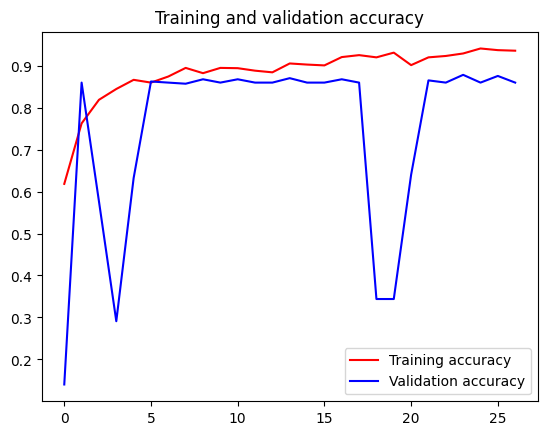

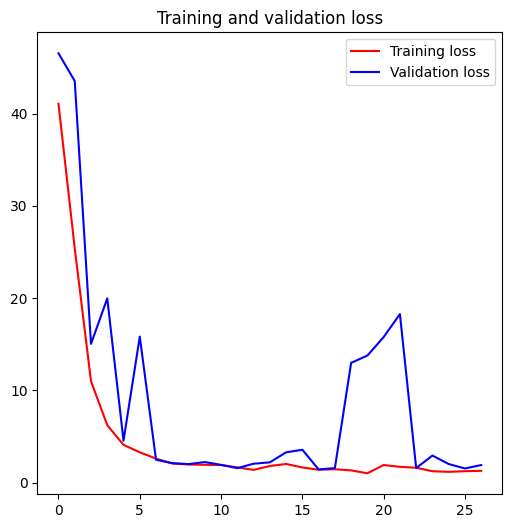

<Figure size 600x600 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))


plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


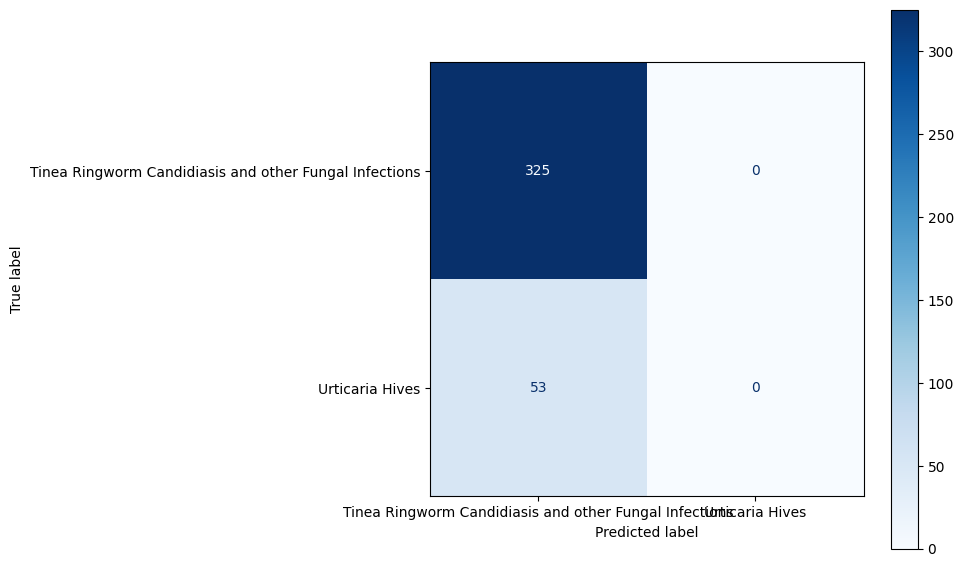

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np

test_true=test_generator.classes
test_pred_raw = model.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

In [34]:
model.save('model_test.keras')